测试文件！！

用来测试单独的步骤，具体的回测文件见backtesting_bt.py

In [64]:
import pandas as pd
import numpy as np
import backtrader as bt

import os
import warnings

warnings.simplefilter('ignore')

股票日行情数据

In [65]:
path = '/Users/ryan/Documents/GitHub/GDHF-Quant-Investment/factor_data/'
file_name = 'eod_price.gz'
data = pd.read_csv(os.path.join(path, file_name))
data.head()

,S_INFO_WINDCODE,TRADE_DT,S_DQ_PRECLOSE,S_DQ_OPEN,S_DQ_HIGH,S_DQ_LOW,S_DQ_CLOSE,S_DQ_VOLUME,S_DQ_PCTCHANGE,S_DQ_AVGPRICE
0,000001.SZ,20170906,11.64,11.59,11.88,11.48,11.70,791621.55,0.5155,11.6914
1,000002.SZ,20170906,23.76,23.79,24.27,23.50,23.80,361719.63,0.1684,23.9400
2,000063.SZ,20170906,24.36,24.28,24.99,24.19,24.95,708125.33,2.4220,24.7464
3,000066.SZ,20170906,8.81,8.80,8.85,8.71,8.81,240351.11,0.0000,8.7852
4,000069.SZ,20170906,8.75,8.74,8.78,8.68,8.72,216449.20,-0.3429,8.7395


In [66]:
columns = ['code', 'datetime', 'preclose', 'open', 'high', 'low', 'close', 'volume', 'pctchange', 'avgprice']
data.columns = columns

In [67]:
data.drop(['preclose', 'pctchange', 'avgprice'], axis=1, inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y%m%d')
data['code'] = data['code'].str.split('.').apply(lambda x: x[0])
data.head(3)

,code,datetime,open,high,low,close,volume
0,000001,2017-09-06,11.59,11.88,11.48,11.70,791621.55
1,000002,2017-09-06,23.79,24.27,23.50,23.80,361719.63
2,000063,2017-09-06,24.28,24.99,24.19,24.95,708125.33


大盘收益率

In [68]:
path = '/Users/ryan/Desktop/quantchina/order-flow-alpha/data'
file_name = 'market_return.csv'
input_file = os.path.join(path, file_name)
df_market = pd.read_csv(input_file, index_col=[0])

df_market['datetime'] = df_market.index
df_market['datetime'] = pd.to_datetime(df_market['datetime'])
df_market.reset_index(drop=True, inplace=True)

df_market.drop('money', axis=1, inplace=True)

df_market['return_predict'] = df_market['close']/df_market['close'].shift(1)-1
df_market['code'] = '399300'
order = ['code', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'return_predict']

df_market = df_market[order]
df_market.head(3)

,code,datetime,open,high,low,close,volume,return_predict
0,399300,2013-12-02,2673.45,2712.98,2627.62,2651.37,1.864382e+10,NaN
1,399300,2013-12-03,2641.95,2691.60,2638.04,2686.98,1.213978e+10,0.013431
2,399300,2013-12-04,2683.92,2740.23,2679.34,2726.52,1.667921e+10,0.014715


预测数据

In [69]:
path = '/Users/ryan/Documents/GitHub/GDHF-Quant-Investment/test_data'
file_name = 'merged_table.csv'
df_pred = pd.read_csv(os.path.join(path, file_name))
df_pred.head(3)

,TRADE_DT,PREDICT_PR,TRUE_PR,CODE
0,2017-02-10,12.926414,6.03,601328_SH.gz
1,2017-02-13,13.045935,6.06,601328_SH.gz
2,2017-02-14,13.043993,6.06,601328_SH.gz


In [70]:
df_pred['return_predict'] = df_pred['PREDICT_PR']/df_pred['PREDICT_PR'].shift(1)-1

df_pred = df_pred.groupby('CODE', group_keys=False).apply(lambda x: x.iloc[1:])
df_pred['CODE'] = df_pred['CODE'].str.split('_').apply(lambda x: x[0])
df_pred.drop(['PREDICT_PR', 'TRUE_PR'], axis=1, inplace=True)

columns = ['datetime', 'code', 'return_predict']
df_pred.columns = columns

df_pred['datetime'] = pd.to_datetime(df_pred['datetime'])
df_pred.head(3)

,datetime,code,return_predict
139049,2017-02-13,000001,-0.012187
139050,2017-02-14,000001,-0.007751
139051,2017-02-15,000001,-0.012022


合并操作

1. 先将预测值表和data (DataFrame)进行合并 left
2. 将benchmark (399300)和data进行合并 outer

In [71]:
data = pd.merge(data, df_pred, on=['datetime','code'], how='left')
data = pd.merge(data, df_market, how='outer')
# data.to_parquet(os.path.join(path, 'test_data_all.parquet'))

策略实现

In [72]:
class GetKdatas(object):
    def __init__(self, secu_lst, benchmark='399300'):
        """
        :parameter secu_lst: a dict contained stocks with starts and ends
        :parameter benchmark: the name of benchmark
        """
        self.secu_lst = secu_lst
        self.benchmark = benchmark

    # 需要更改开始和结束时间
    @staticmethod
    def get_single_kdata(code, start='2020-01-01', end='2021-08-01', index=False):
        df = data[data['code']==code]
        df = df[df.datetime.between(start, end)]
        # df['datetime'] = pd.to_datetime(df['datetime'])
        return df[['datetime', 'open', 'high', 'low', 'close', 'volume', 'return_predict']]

    def get_all_kdata(self):
        kdata = {}
        for secu in set(self.secu_lst):
            secu_kdata = self.get_single_kdata(secu, self.secu_lst[secu]['start'], self.secu_lst[secu]['end'])
            kdata[secu] = secu_kdata.reset_index(drop=True)
        return kdata

    def merge_period(self):
        all_kdata = self.get_all_kdata()
        benchmark_start = min(self.secu_lst.values(), key=lambda x: x['start'])['start']
        benchmark_end = max(self.secu_lst.values(), key=lambda x: x['end'])['end']
        all_kdata['benchmark'] = self.get_single_kdata(self.benchmark, benchmark_start, benchmark_end,True)

        for secu in set(all_kdata.keys()) - set(['benchmark']):
            secu_kdata = all_kdata['benchmark'][['datetime']].merge(all_kdata[secu], how='left')
            secu_kdata['suspend'] = 0
            secu_kdata.loc[secu_kdata['open'].isnull(), 'suspend'] = 1  # 标记为停盘日
            secu_kdata.set_index(['datetime'], inplace=True)  # 设date为index
            end = secu_lst[secu]['end']
            secu_kdata.fillna(method='ffill', inplace=True)  # start后的数据用前日数据进行补充
            secu_kdata.fillna(value=0, inplace=True)  # start前的数据用0补充
            secu_kdata.loc[(secu_kdata.index > end), 'suspend'] = 1
            all_kdata[secu] = secu_kdata

        _ = all_kdata.pop('benchmark')
        return all_kdata

In [73]:
# 测试class是否有效
secu_lst = {'603160': {'start': '2017-02-14', 'end': '2022-03-01'},
            '000001': {'start': '2017-02-14', 'end': '2022-03-01'}}

kdata = GetKdatas(secu_lst).merge_period()
print(kdata)

{'000001':              open   high    low  close      volume  return_predict  suspend
datetime                                                                   
2017-02-14   9.41   9.42   9.37   9.40   362404.60       -0.007751        0
2017-02-15   9.40   9.54   9.39   9.45   756613.06       -0.012022        0
2017-02-16   9.45   9.50   9.42   9.46   411161.13       -0.024275        0
2017-02-17   9.46   9.49   9.37   9.39   423774.97        0.010614        0
2017-02-20   9.40   9.58   9.40   9.56   898755.39       -0.018733        0
...           ...    ...    ...    ...         ...             ...      ...
2022-02-23  16.30  16.31  16.04  16.19   886742.44       -0.045125        0
2022-02-24  16.13  16.15  15.80  15.91  1324086.85       -0.000416        0
2022-02-25  15.99  16.08  15.87  15.90   726397.07        0.010300        0
2022-02-28  15.90  15.92  15.62  15.75   723990.45       -0.021264        0
2022-03-01  15.79  15.95  15.62  15.92   935040.34        0.034496        0



In [74]:
class CommInfoPro(bt.CommInfoBase):

    params = (
        ('stamp_duty', 0.001),  # 印花税率
        ('stamp_duty_fe', 1),  # 最低印花税
        ('commission', 0.001),  # 佣金率
        ('commission_fee', 5),  # 最低佣金费
        ('stocklike', True), # 股票
        ('commtype', bt.CommInfoBase.COMM_PERC), # 按比例收
    )

    def _getcommission(self, size, price, pseudoexec):
        '''
        If size is greater than 0, this indicates a long / buying of shares.
        If size is less than 0, it idicates a short / selling of shares.
        '''

        if size > 0:  # 买入，不考虑印花税
            return max(size * price * self.p.commission, self.p.commission_fee)
        elif size < 0:  # 卖出，考虑印花税
            return max(size * price * (self.p.stamp_duty + self.p.commission), self.p.stamp_duty_fe)
        else:
            return 0  # just in case for some reason the size is 0.

class PandasData(bt.feeds.DataBase):
    params = (
        ('datetime', 0),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 5)
    )

class PandasData_Extend(bt.feeds.PandasData):
    lines = ('return_predict',)
    params = (
        ('return_predict', -1),
    )

class TestStrategy(bt.Strategy):

    def __init__(self):
        self.order = None
        self.buy_lst = []

    def log(self, txt, dt=None):
        '''输出日志'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def prenext(self):
        '''检验数据是否对齐'''
        pass
    
    def downcast(self, amount, lot):
        return abs(amount//lot*lot)
    
    def next(self):
        if self.order:
            return
        
        if self.datas[0].datetime.date(0) == end_date:
            return
        
        self.log(f'{self.broker.getvalue():.2f}, {[(x, self.getpositionbyname(x).size) for x in self.buy_lst]}')
        if len(self.buy_lst)<2:    #! 需要修改该部分内容
            for secu in set(self.getdatanames()) - set(self.buy_lst):
                data = self.getdatabyname(secu)
                # 设置买入条件
                if (data.return_predict > 0):
                    # 买入价格为当前资金的多少倍
                    order_value = self.broker.getvalue()*0.1
                    order_amount = self.downcast(order_value/data.close[0], 100)
                    self.order = self.buy(data, size=order_amount, name=secu)
                    self.log(f'Buy:{secu}, price:{data.close[0]:.2f}, amount:{order_amount}')
                    self.buy_lst.append(secu)
                    print(self.buy_lst)
        
        elif self.position:
            print('test!')
            now_list = []
            for secu in self.buy_lst:
                data = self.getdatabyname(secu)
                # 设置卖出条件
                if (data.return_predict < 0):
                    # self.order = self.order_target_percent(data, 0, name=secu)
                    # self.order = self.sell(data)
                    self.order = self.sell(data, size = self.getposition(data).size)
                    self.log(f"Sell: {secu}, price:{data.close[0]:.2f}, pct: 0")
                    continue
                now_list.append(secu)
            self.buy_lst = now_list.copy()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""Buy:{order.info['name']}, amount:{order.executed.size}, price:{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""Sell:{order.info['name']}, amount:{order.executed.size}, price:{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

# 填充需要回测的股票池
secu_lst = {'603160':{'start':'2017-02-14','end':'2022-03-31'},
            '000002':{'start':'2017-02-14','end':'2022-03-01'},
            }

kdata = GetKdatas(secu_lst).merge_period()
kdata = dict(sorted(kdata.items()))
    
# 开始回测
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

for secu in kdata.keys():
    df = kdata[secu]
    
    data = PandasData_Extend(dataname=df, 
    fromdate=df.index[0], 
    todate=df.index[-1]
    )

    cerebro.adddata(data, name=secu)

end_date = df.index[-1]


# 设置初始资本为1 million
startcash = 10**6
cerebro.broker.setcash(startcash)
print(f"初始资金{cerebro.broker.getvalue()}")
# 设置交易手续费
cerebro.broker.addcommissioninfo(CommInfoPro())

# 加入指标
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_sharpe')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_annrtn')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_dd')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='_pyfolio')
# 运行回测系统
thestrats = cerebro.run()
# 获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
# 打印结果
print(f'结束资金: {round(portvalue, 2)}')

初始资金1000000
2017-02-14, 1000000.00, []
2017-02-14, Buy:000002, price:20.91, amount:4700.0
['000002']
2017-02-15, Buy:000002, amount:4700.0, price:20.90
2017-02-15, 998914.00, [('000002', 4700.0)]
2017-02-16, 998961.00, [('000002', 4700.0)]
2017-02-16, Buy:603160, price:93.42, amount:1000.0
['000002', '603160']
2017-02-17, Buy:603160, amount:1000.0, price:93.51
2017-02-17, 997178.00, [('000002', 4700.0), ('603160', 1000.0)]
test!
2017-02-20, 996547.00, [('000002', 4700.0), ('603160', 1000.0)]
test!
2017-02-20, Sell: 603160, price:91.43, pct: 0
2017-02-21, Sell:AutoOrderedDict(), amount:-1000.0, price:91.45
2017-02-21, 998305.00, [('000002', 4700.0)]
2017-02-22, 997929.00, [('000002', 4700.0)]
2017-02-23, 997412.00, [('000002', 4700.0)]
2017-02-24, 997083.00, [('000002', 4700.0)]
2017-02-27, 996143.00, [('000002', 4700.0)]
2017-02-28, 996190.00, [('000002', 4700.0)]
2017-03-01, 996049.00, [('000002', 4700.0)]
2017-03-01, Buy:603160, price:97.11, amount:1000.0
['000002', '603160']
2017-03

[[<Figure size 864x576 with 6 Axes>]]

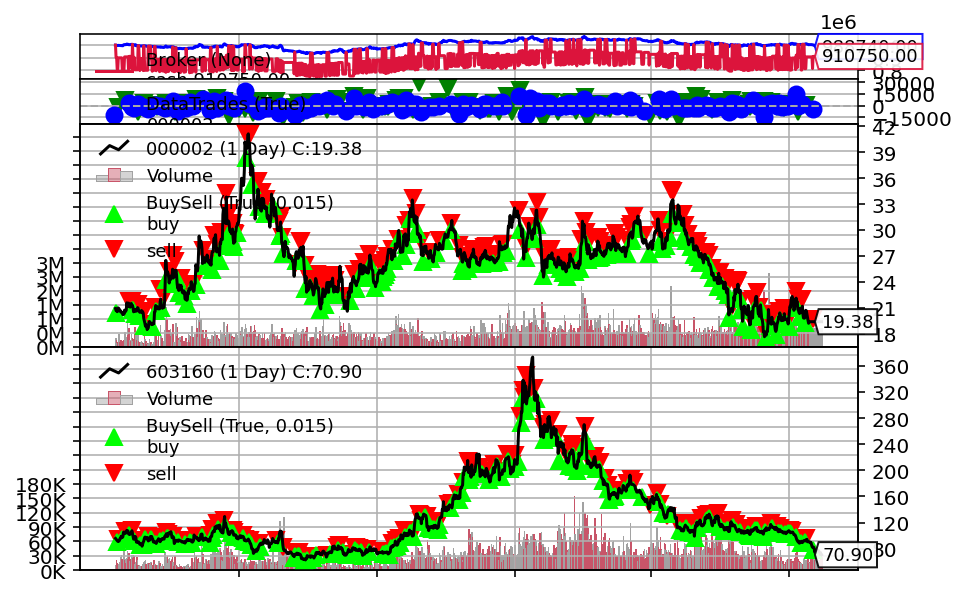

In [75]:
cerebro.plot(iplot=False)

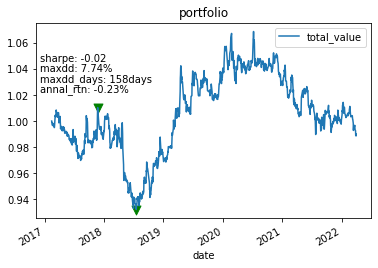

In [76]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

thestrat = thestrats[0]
pyfolio = thestrat.analyzers._pyfolio.get_analysis()
returns = pyfolio['returns'].values()
returns = pd.DataFrame(list(zip(pyfolio['returns'].keys(),pyfolio['returns'].values())), columns=['date','total_value'])


sharpe = np.round(np.sqrt(252) * returns['total_value'].mean() / returns['total_value'].std(), 4)
returns['total_value']=returns['total_value']+1
returns['total_value'] = returns['total_value'].cumprod()
annal_rtn = np.round(returns['total_value'].iloc[-1]**(252/len(returns))-1, 4)*100
dd = 1-returns['total_value']/np.maximum.accumulate(returns['total_value'])
end_idx = np.argmax(dd)
start_idx = np.argmax(returns['total_value'].iloc[:end_idx])
maxdd_days = end_idx-start_idx
maxdd = np.round(max(dd), 4)*100

returns = returns.set_index('date')
ax=returns.plot(y='total_value')
plt.text(0.01,0.8, f'sharpe: {sharpe:.2f}', transform=ax.transAxes)
plt.text(0.01,0.75, f'maxdd: {maxdd:.2f}%', transform=ax.transAxes)
plt.text(0.01,0.7, f'maxdd_days: {maxdd_days:}days', transform=ax.transAxes)
plt.text(0.01,0.65, f'annal_rtn: {(annal_rtn):.2f}%', transform=ax.transAxes)
plt.scatter([returns.index[start_idx], returns.index[end_idx]], [returns.iloc[start_idx], returns.iloc[end_idx]],
            s = 80, c = 'g', marker = 'v', label = 'MaxDrawdown Duration')
plt.title('portfolio')
plt.show()

In [77]:
df_market.rename(columns={'datetime':'date', 'return_predict':'market_return'}, inplace=True)
returns = pd.merge(returns, df_market[['date','market_return']], on='date', how='left')
returns['market_return'] = 1+returns['market_return']
returns = returns.set_index('date')

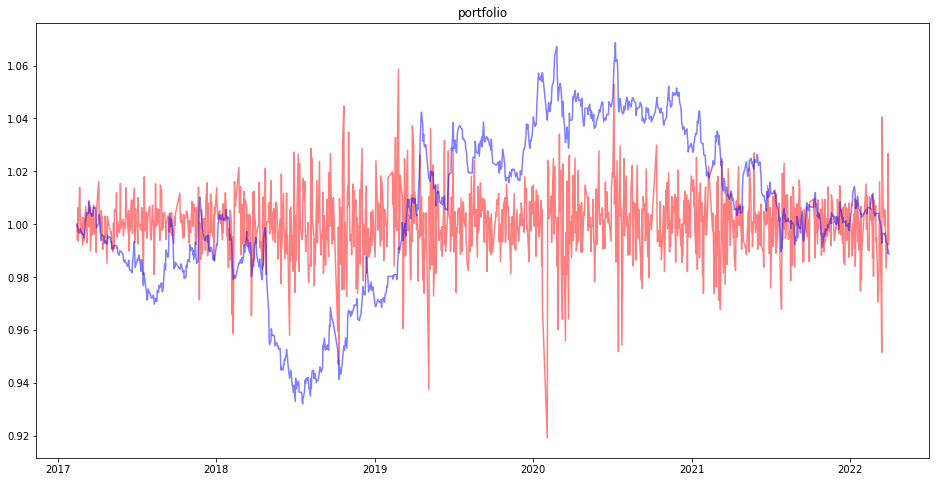

In [78]:
# ax=returns.plot(y='total_value')
fig = plt.figure(figsize=(16,8))
plt.plot(returns['market_return'], label='market_return', color='red', alpha=0.5)
plt.plot(returns['total_value'], label='portfolio_return', color='blue', alpha=0.5)
# plt.text(0.01,0.8, f'sharpe: {sharpe:.2f}')
# plt.text(0.01,0.75, f'maxdd: {maxdd:.2f}%', transform=ax.transAxes)
# plt.text(0.01,0.7, f'maxdd_days: {maxdd_days:}days', transform=ax.transAxes)
# plt.text(0.01,0.65, f'annal_rtn: {(annal_rtn):.2f}%', transform=ax.transAxes)
# plt.scatter([returns.index[start_idx], returns.index[end_idx]], [returns.iloc[start_idx], returns.iloc[end_idx]],
#             s = 80, c = 'g', marker = 'v', label = 'MaxDrawdown Duration')
plt.title('portfolio')
plt.show()

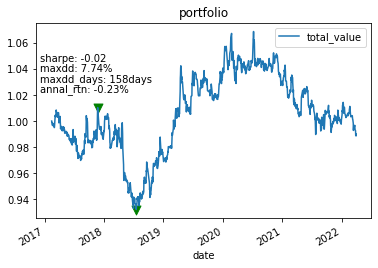

: 

In [79]:
# 策略分析--画图函数
def plot_strategy(pyfolio):
    returns = pyfolio['returns'].values()
    returns = pd.DataFrame(list(zip(pyfolio['returns'].keys(),pyfolio['returns'].values())), columns=['date','total_value'])
    
    sharpe = np.round(np.sqrt(252) * returns['total_value'].mean() / returns['total_value'].std(), 4)
    returns['total_value']=returns['total_value']+1
    returns['total_value'] = returns['total_value'].cumprod()
    annal_rtn = np.round(returns['total_value'].iloc[-1]**(252/len(returns))-1, 4)*100
    dd = 1-returns['total_value']/np.maximum.accumulate(returns['total_value'])
    end_idx = np.argmax(dd)
    start_idx = np.argmax(returns['total_value'].iloc[:end_idx])
    maxdd_days = end_idx-start_idx
    maxdd = np.round(max(dd), 4)*100
    
    returns = returns.set_index('date')
    ax=returns.plot(y='total_value')
    plt.text(0.01,0.8, f'sharpe: {sharpe:.2f}', transform=ax.transAxes)
    plt.text(0.01,0.75, f'maxdd: {maxdd:.2f}%', transform=ax.transAxes)
    plt.text(0.01,0.7, f'maxdd_days: {maxdd_days:}days', transform=ax.transAxes)
    plt.text(0.01,0.65, f'annal_rtn: {(annal_rtn):.2f}%', transform=ax.transAxes)
    plt.scatter([returns.index[start_idx], returns.index[end_idx]], [returns.iloc[start_idx], returns.iloc[end_idx]],
                s = 80, c = 'g', marker = 'v', label = 'MaxDrawdown Duration')
    plt.title('portfolio')
    plt.show()

plot_strategy(pyfolio)